In [11]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



#1.Importing Libraries



In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
# from torch_receptive_field import PytorchReceptiveField
!pip install torchsummary

# 2. Mount Google Drive to get the files individual files


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!rm -rf '/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/__pycache__'
!ls -lrt '/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/'

total 666
-rw------- 1 root root   4771 Mar  3  2020  dataTorchTransformLoad.py
-rw------- 1 root root   1779 Sep 12 09:32  trainModel.py
-rw------- 1 root root   3326 Sep 12 09:37  customModel.py
-rw------- 1 root root   2214 Sep 12 09:43  vs_net.py
-rw------- 1 root root   1541 Sep 12 09:50  testModel.py
-rw------- 1 root root 666040 Sep 12 09:58 'Advanced Convolutions.ipynb'


## 2.1 Add Googledrive path to the systempath  


In [15]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/')

# Importing Custom Libraries
 1. DataTransformers
 2. TrainModel
 3. TestModel
 4. Custom Model
 5. Advanced Model



In [16]:
import dataTorchTransformLoad as dtl
import trainModel
import testModel
import customModel
import vs_net

# 3. Train - Test Data Load with torch transforms


In [17]:
train,test,train_loader,test_loader = dtl.data_transform_and_load_function('CIFAR10',64)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## 4.1 Data Statistics

In [18]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


## 4.2 Display data

[['plane' 'dog' 'deer' 'deer' 'truck' 'cat' 'truck' 'truck']
 ['cat' 'cat' 'plane' 'horse' 'plane' 'dog' 'dog' 'deer']
 ['car' 'car' 'frog' 'car' 'frog' 'dog' 'ship' 'cat']
 ['car' 'frog' 'deer' 'bird' 'deer' 'bird' 'cat' 'horse']
 ['car' 'cat' 'cat' 'ship' 'horse' 'plane' 'plane' 'plane']
 ['truck' 'plane' 'frog' 'horse' 'ship' 'deer' 'bird' 'plane']
 ['cat' 'dog' 'bird' 'truck' 'dog' 'cat' 'deer' 'dog']
 ['dog' 'frog' 'horse' 'frog' 'ship' 'deer' 'plane' 'truck']]


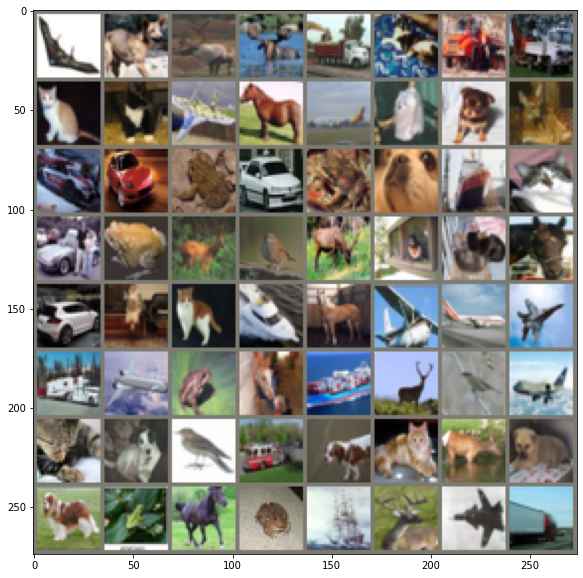

In [19]:
# functions to show an image
def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

random.seed(1)
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
random.seed(1)
imageshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

## 5. Previous Architecture

In [20]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = customModel.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             270
       BatchNorm2d-2           [-1, 10, 30, 30]              20
              ReLU-3           [-1, 10, 30, 30]               0
           Dropout-4           [-1, 10, 30, 30]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
              ReLU-7           [-1, 10, 28, 28]               0
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           1,440
      BatchNorm2d-10           [-1, 16, 26, 26]              32
             ReLU-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
        MaxPool2d-13           [-1, 16, 13, 13]               0
           Conv2d-14           [-1

## 10K Params, Average loss: 0.9891, Accuracy: 6501/10000 (65.01%)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.299631118774414 Batch_id=0 Accuracy=17.19:   0%|          | 0/782 [00:00<?, ?it/s]/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/trainModel.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(True)
Loss=1.554313063621521 Batch_id=781 Accuracy=38.26: 100%|██████████| 782/782 [00:17<00:00, 45.45it/s]
/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/testModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(


Test set: Average loss: 1.4517, Accuracy: 4711/10000 (47.11%)

EPOCH: 1


Loss=1.7062358856201172 Batch_id=781 Accuracy=50.18: 100%|██████████| 782/782 [00:17<00:00, 45.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3322, Accuracy: 5142/10000 (51.42%)

EPOCH: 2


Loss=1.5329116582870483 Batch_id=781 Accuracy=54.63: 100%|██████████| 782/782 [00:16<00:00, 46.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2193, Accuracy: 5678/10000 (56.78%)

EPOCH: 3


Loss=0.8206867575645447 Batch_id=781 Accuracy=56.81: 100%|██████████| 782/782 [00:17<00:00, 45.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2221, Accuracy: 5641/10000 (56.41%)

EPOCH: 4


Loss=1.4045182466506958 Batch_id=781 Accuracy=58.25: 100%|██████████| 782/782 [00:16<00:00, 46.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1297, Accuracy: 5940/10000 (59.40%)

EPOCH: 5


Loss=1.2614964246749878 Batch_id=781 Accuracy=58.95: 100%|██████████| 782/782 [00:17<00:00, 44.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1018, Accuracy: 6083/10000 (60.83%)

EPOCH: 6


Loss=1.3409751653671265 Batch_id=781 Accuracy=59.82: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0538, Accuracy: 6191/10000 (61.91%)

EPOCH: 7


Loss=1.3067704439163208 Batch_id=781 Accuracy=60.84: 100%|██████████| 782/782 [00:17<00:00, 45.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0925, Accuracy: 6076/10000 (60.76%)

EPOCH: 8


Loss=1.8083672523498535 Batch_id=781 Accuracy=61.20: 100%|██████████| 782/782 [00:16<00:00, 46.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0466, Accuracy: 6281/10000 (62.81%)

EPOCH: 9


Loss=1.561999797821045 Batch_id=781 Accuracy=61.74: 100%|██████████| 782/782 [00:17<00:00, 45.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0616, Accuracy: 6174/10000 (61.74%)

EPOCH: 10


Loss=0.8726559281349182 Batch_id=781 Accuracy=62.17: 100%|██████████| 782/782 [00:17<00:00, 44.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0290, Accuracy: 6312/10000 (63.12%)

EPOCH: 11


Loss=0.9232962131500244 Batch_id=781 Accuracy=62.32: 100%|██████████| 782/782 [00:17<00:00, 45.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0066, Accuracy: 6347/10000 (63.47%)

EPOCH: 12


Loss=0.8358609080314636 Batch_id=781 Accuracy=62.59: 100%|██████████| 782/782 [00:17<00:00, 44.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0087, Accuracy: 6449/10000 (64.49%)

EPOCH: 13


Loss=1.2731410264968872 Batch_id=781 Accuracy=63.11: 100%|██████████| 782/782 [00:18<00:00, 42.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9998, Accuracy: 6428/10000 (64.28%)

EPOCH: 14


Loss=1.3015142679214478 Batch_id=781 Accuracy=63.21: 100%|██████████| 782/782 [00:18<00:00, 42.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9892, Accuracy: 6505/10000 (65.05%)

EPOCH: 15


Loss=1.10362708568573 Batch_id=781 Accuracy=63.42: 100%|██████████| 782/782 [00:17<00:00, 44.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0257, Accuracy: 6384/10000 (63.84%)

EPOCH: 16


Loss=1.0596776008605957 Batch_id=781 Accuracy=63.93: 100%|██████████| 782/782 [00:17<00:00, 44.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9765, Accuracy: 6528/10000 (65.28%)

EPOCH: 17


Loss=1.031732201576233 Batch_id=781 Accuracy=63.96: 100%|██████████| 782/782 [00:17<00:00, 43.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9845, Accuracy: 6518/10000 (65.18%)

EPOCH: 18


Loss=0.8565481305122375 Batch_id=781 Accuracy=64.42: 100%|██████████| 782/782 [00:18<00:00, 42.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9896, Accuracy: 6517/10000 (65.17%)

EPOCH: 19


Loss=0.7401723861694336 Batch_id=781 Accuracy=64.50: 100%|██████████| 782/782 [00:18<00:00, 43.15it/s]



Test set: Average loss: 0.9891, Accuracy: 6501/10000 (65.01%)



Text(0.5, 1.0, 'Test Accuracy')

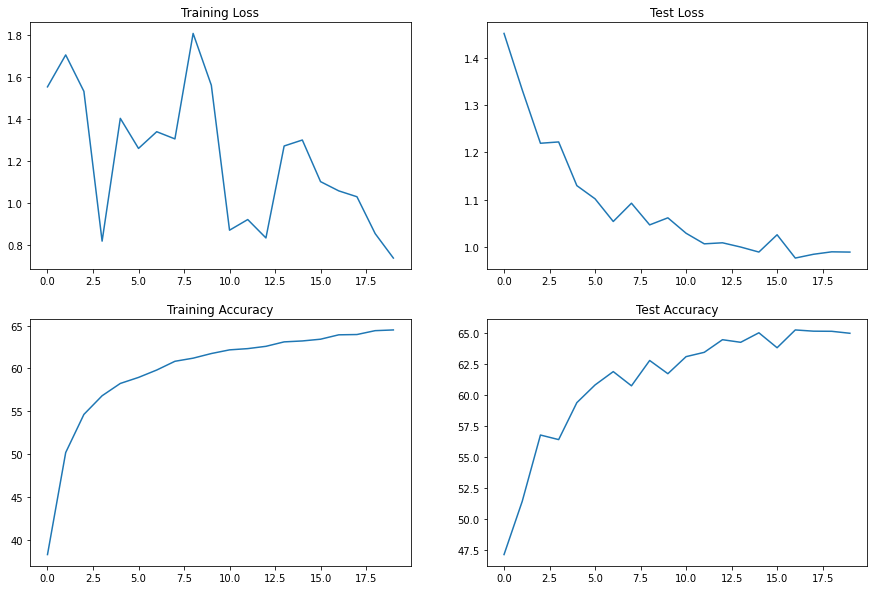

In [21]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR
model = customModel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
EPOCHS = 20
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_acc,tr_losses = trainModel.train(model, device, train_loader, optimizer, epoch,'Normal', True, EPOCHS-1)
    train_losses.append(tr_losses)
    train_acc.append(tr_acc)
    ts_acc,ts_loss = testModel.test(model, device, test_loader,epoch,'Normal',True, EPOCHS-1)
    test_losses.append(ts_loss)
    test_acc.append(ts_acc)    

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Architecture (With Advanced Convolution)

- change the code such that it uses GPU
- change the architecture to C1C2C3C40 (basically 3 MPs)
- total RF must be more than 44
- one of the layers must use Depthwise Separable Convolution
- one of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes   (optional)
- achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. 

- Advanced Convolution with 604K Params
- Test set: Average loss: 0.4949, Accuracy: 8409/10000 (84.09%)

In [22]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = vs_net.Net1().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.319889783859253 Batch_id=0 Accuracy=9.38:   0%|          | 0/782 [00:00<?, ?it/s]/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/trainModel.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(True)
Loss=0.8969246745109558 Batch_id=781 Accuracy=51.06: 100%|██████████| 782/782 [00:30<00:00, 26.02it/s]
/content/drive/My Drive/Colab Notebooks/EVA 5/Advanced Convolution/testModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(


Test set: Average loss: 1.2113, Accuracy: 5775/10000 (57.75%)

EPOCH: 1


Loss=0.8269083499908447 Batch_id=781 Accuracy=68.03: 100%|██████████| 782/782 [00:29<00:00, 26.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8973, Accuracy: 6946/10000 (69.46%)

EPOCH: 2


Loss=0.6296890377998352 Batch_id=781 Accuracy=73.92: 100%|██████████| 782/782 [00:30<00:00, 26.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8333, Accuracy: 7189/10000 (71.89%)

EPOCH: 3


Loss=0.8232828974723816 Batch_id=781 Accuracy=77.39: 100%|██████████| 782/782 [00:29<00:00, 26.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7628, Accuracy: 7385/10000 (73.85%)

EPOCH: 4


Loss=0.7620680332183838 Batch_id=781 Accuracy=79.25: 100%|██████████| 782/782 [00:29<00:00, 26.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6088, Accuracy: 7982/10000 (79.82%)

EPOCH: 5


Loss=0.8030156493186951 Batch_id=781 Accuracy=81.01: 100%|██████████| 782/782 [00:29<00:00, 26.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5856, Accuracy: 8040/10000 (80.40%)

EPOCH: 6


Loss=1.4241982698440552 Batch_id=781 Accuracy=82.57: 100%|██████████| 782/782 [00:29<00:00, 26.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6302, Accuracy: 7885/10000 (78.85%)

EPOCH: 7


Loss=0.8227251172065735 Batch_id=781 Accuracy=83.50: 100%|██████████| 782/782 [00:29<00:00, 26.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5335, Accuracy: 8241/10000 (82.41%)

EPOCH: 8


Loss=0.5570599436759949 Batch_id=781 Accuracy=84.43: 100%|██████████| 782/782 [00:30<00:00, 25.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5578, Accuracy: 8123/10000 (81.23%)

EPOCH: 9


Loss=0.7282997369766235 Batch_id=781 Accuracy=85.44: 100%|██████████| 782/782 [00:29<00:00, 26.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5315, Accuracy: 8225/10000 (82.25%)

EPOCH: 10


Loss=0.4702499508857727 Batch_id=781 Accuracy=86.14: 100%|██████████| 782/782 [00:29<00:00, 26.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4957, Accuracy: 8349/10000 (83.49%)

EPOCH: 11


Loss=0.24010485410690308 Batch_id=781 Accuracy=86.64: 100%|██████████| 782/782 [00:29<00:00, 26.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4966, Accuracy: 8333/10000 (83.33%)

EPOCH: 12


Loss=0.10011167824268341 Batch_id=781 Accuracy=87.20: 100%|██████████| 782/782 [00:29<00:00, 26.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4997, Accuracy: 8305/10000 (83.05%)

EPOCH: 13


Loss=0.29489666223526 Batch_id=781 Accuracy=87.73: 100%|██████████| 782/782 [00:30<00:00, 25.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4895, Accuracy: 8328/10000 (83.28%)

EPOCH: 14


Loss=0.8273074626922607 Batch_id=781 Accuracy=88.53: 100%|██████████| 782/782 [00:29<00:00, 26.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5034, Accuracy: 8317/10000 (83.17%)

EPOCH: 15


Loss=0.5896559357643127 Batch_id=781 Accuracy=88.84: 100%|██████████| 782/782 [00:29<00:00, 26.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4696, Accuracy: 8423/10000 (84.23%)

EPOCH: 16


Loss=0.57621830701828 Batch_id=781 Accuracy=89.23: 100%|██████████| 782/782 [00:30<00:00, 25.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4768, Accuracy: 8408/10000 (84.08%)

EPOCH: 17


Loss=0.2973848879337311 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [00:29<00:00, 26.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4913, Accuracy: 8380/10000 (83.80%)

EPOCH: 18


Loss=0.37912312150001526 Batch_id=781 Accuracy=90.03: 100%|██████████| 782/782 [00:30<00:00, 25.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4732, Accuracy: 8437/10000 (84.37%)

EPOCH: 19


Loss=0.36675822734832764 Batch_id=781 Accuracy=90.48: 100%|██████████| 782/782 [00:29<00:00, 26.23it/s]



Test set: Average loss: 0.4949, Accuracy: 8409/10000 (84.09%)



Text(0.5, 1.0, 'Test Accuracy')

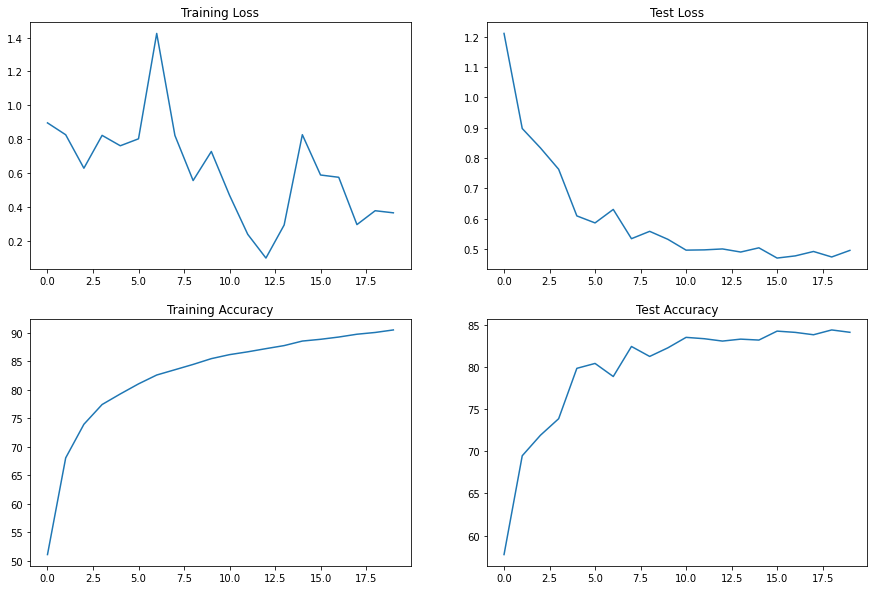

In [23]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR
model = vs_net.Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
EPOCHS = 20
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_acc,tr_losses = trainModel.train(model, device, train_loader, optimizer, epoch,'Normal', True, EPOCHS-1)
    train_losses.append(tr_losses)
    train_acc.append(tr_acc)
    ts_acc,ts_loss = testModel.test(model, device, test_loader,epoch,'Normal',True, EPOCHS-1)
    test_losses.append(ts_loss)
    test_acc.append(ts_acc)    

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")